## 2. Create 2D Occupancy grid

In [1]:
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Step 1: Load the PLY file
point_cloud = o3d.io.read_point_cloud("filtered_pointcloud_week1_notebook.ply") #week 1 maze


In [ ]:
""" Visualise filtered point cloud"""
o3d.visualization.draw_geometries([point_cloud]) 

In [3]:
"""flatten z coordinates"""
point_cloud_np = np.asarray(point_cloud.points) 
# point_cloud_np = point_cloud_np[:, [0,2]] #removes z dimension
point_cloud_np[:, 1] = 0 # sets z dimension to 0

print(point_cloud_np[0, :])

[-5.19326019  0.         -9.71401978]


In [4]:
"""Show flattened maze"""
flattened_pc = o3d.geometry.PointCloud()
flattened_pc.points = o3d.utility.Vector3dVector(point_cloud_np)

o3d.visualization.draw_geometries([flattened_pc]) 

### Create Grid

In [21]:
import numpy as np

# Indices: y at 0, z at 1, x at 2.
# only use x and y

y_coords = point_cloud_np[:, 0]
x_coords = point_cloud_np[:, 2]

resolution = 0.2 # grid size

# min and max points
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)

# Compute the size of the grid
x_size = int(np.ceil((x_max - x_min) / resolution))
y_size = int(np.ceil((y_max - y_min) / resolution))


#count number of points per grid cell
count_grid = np.zeros((y_size, x_size), dtype=np.int32)
for i in range(len(x_coords)):
    # Translate coordinates to grid indices
    x_idx = int((x_coords[i] - x_min) / resolution)
    y_idx = int((y_coords[i] - y_min) / resolution)
    count_grid[y_idx, x_idx] += 1


#if more points in cell than threshold, mark as occupied
threshold = 5
grid = np.zeros_like(count_grid, dtype=np.uint8)
grid[count_grid >= threshold] = 1 #initialise grid, 0 = free, 1 = occupied


print("Grid shape:", grid.shape)


Grid shape: (85, 65)


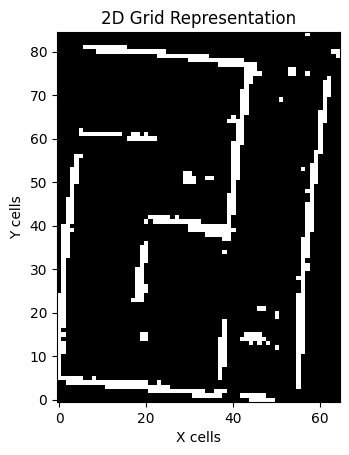

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(grid, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Grid')
plt.show()

#TODO need to rotate to the left right after loading the point cloud (in filter_keypoints)
